In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import joblib
import matplotlib.pyplot as plt
import seaborn as sns


In [2]:
csv_path = 'data/diabetes_prediction_dataset.csv'
data = pd.read_csv(csv_path)
print(f"Total Samples: {len(data)}")
print("Dataset Preview:")
print(data.head())
print("\nDataset Info:")
print(data.info())
print("\nMissing Values:")
print(data.isnull().sum())


Total Samples: 100000
Dataset Preview:
   gender   age  hypertension  heart_disease smoking_history    bmi  \
0  Female  80.0             0              1           never  25.19   
1  Female  54.0             0              0         No Info  27.32   
2    Male  28.0             0              0           never  27.32   
3  Female  36.0             0              0         current  23.45   
4    Male  76.0             1              1         current  20.14   

   HbA1c_level  blood_glucose_level  diabetes  
0          6.6                  140         0  
1          6.6                   80         0  
2          5.7                  158         0  
3          5.0                  155         0  
4          4.8                  155         0  

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 9 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   gender         

In [ ]:
def preprocess_data(df):
    df_processed = df.copy()
    
    
    print(f"\nDuplicates found: {df_processed.duplicated().sum()}")
    df_processed = df_processed.drop_duplicates()
    print(f"Data shape after removing duplicates: {df_processed.shape}")
    

    print("\nCategorical variables preprocessing:")

    
    le_smoking = LabelEncoder()
    df_processed['smoking_history_encoded'] = le_smoking.fit_transform(df_processed['smoking_history'])
    print(f"Smoking history mapping: {dict(zip(le_smoking.classes_, le_smoking.transform(le_smoking.classes_)))}")
    
    print("\nTarget distribution:")
    print(df_processed['diabetes'].value_counts())
    print(f"Diabetes rate: {df_processed['diabetes'].mean():.2%}")
    
    return df_processed,le_smoking


In [4]:
data_processed, smoking_encoder = preprocess_data(data)



Duplicates found: 3854
Data shape after removing duplicates: (96146, 9)

Categorical variables preprocessing:
Smoking history mapping: {'No Info': 0, 'current': 1, 'ever': 2, 'former': 3, 'never': 4, 'not current': 5}

Target distribution:
diabetes
0    87664
1     8482
Name: count, dtype: int64
Diabetes rate: 8.82%


In [5]:
features = ['age', 'hypertension', 'heart_disease', 
            'smoking_history_encoded', 'bmi', 'HbA1c_level', 'blood_glucose_level']
X = data_processed[features]
y = data_processed['diabetes']

print(f"\nFeature matrix shape: {X.shape}")
print(f"Target vector shape: {y.shape}")



Feature matrix shape: (96146, 7)
Target vector shape: (96146,)


In [6]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"\nTrain set shape: {X_train.shape}")
print(f"Test set shape: {X_test.shape}")
print(f"Train diabetes rate: {y_train.mean():.2%}")
print(f"Test diabetes rate: {y_test.mean():.2%}")



Train set shape: (76916, 7)
Test set shape: (19230, 7)
Train diabetes rate: 8.82%
Test diabetes rate: 8.82%


In [7]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [8]:
from sklearn.utils.class_weight import compute_class_weight

class_counts = y_train.value_counts()
print(f"Class distribution:\n{class_counts}")
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weight_dict = dict(zip(np.unique(y_train), class_weights))
print(f"Calculated class weights: {class_weight_dict}")

rf_model = RandomForestClassifier(
    n_estimators=200,
    max_depth=15,
    min_samples_split=5,
    min_samples_leaf=2,
    class_weight='balanced',
    random_state=42,
    n_jobs=-1
)

rf_model.fit(X_train_scaled, y_train)


Class distribution:
diabetes
0    70130
1     6786
Name: count, dtype: int64
Calculated class weights: {0: 0.5483815770711535, 1: 5.667256115531978}


RandomForestClassifier(class_weight='balanced', max_depth=15,
                       min_samples_leaf=2, min_samples_split=5,
                       n_estimators=200, n_jobs=-1, random_state=42)

Accuracy: 0.9304

Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.94      0.96     17534
           1       0.57      0.85      0.68      1696

    accuracy                           0.93     19230
   macro avg       0.78      0.90      0.82     19230
weighted avg       0.95      0.93      0.94     19230


Confusion Matrix:
[[16445  1089]
 [  250  1446]]


Text(0.5, 1.0, 'Confusion Matrix')

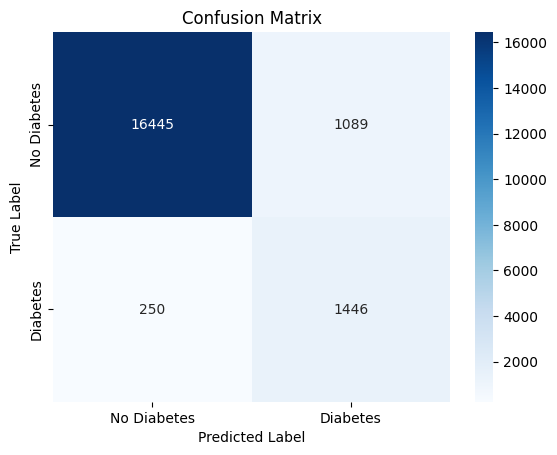

In [9]:
y_pred = rf_model.predict(X_test_scaled)
y_pred_proba = rf_model.predict_proba(X_test_scaled)

accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred))
print("\nConfusion Matrix:")
cm = confusion_matrix(y_test, y_pred)
print(cm)

sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['No Diabetes', 'Diabetes'],
            yticklabels=['No Diabetes', 'Diabetes'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')


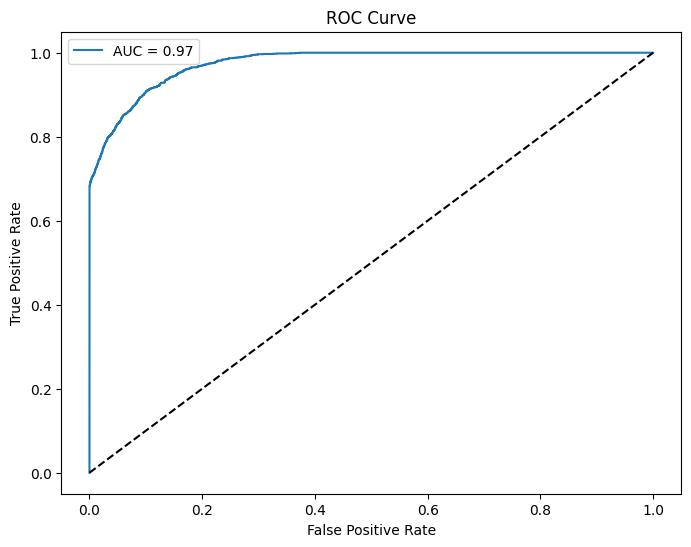

In [20]:
# ROC Curve
roc_auc = roc_auc_score(y_test, y_pred_proba[:, 1])
fpr, tpr, _ = roc_curve(y_test, y_pred_proba[:, 1])

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'AUC = {roc_auc:.2f}')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

In [11]:

joblib.dump(rf_model, 'diabetes_model.pkl')       
joblib.dump(scaler, 'scaler.pkl')                          
joblib.dump(smoking_encoder, 'smoking_encoder.pkl')        
            


['smoking_encoder.pkl']

In [ ]:

def predict_diabetes_api_ready(new_data, model, scaler, smoking_encoder, feature_names, threshold=0.5):
    
    
    if isinstance(new_data, dict):
       new_data = pd.DataFrame([new_data])
    elif isinstance(new_data, list):
        new_data = pd.DataFrame(new_data)

    
    df = new_data.copy()
    
 
    yes_no_map = {'yes': 1, 'no': 0}

 
    for col in ['hypertension', 'heart_disease']:
        df[col] = df[col].str.lower().map(yes_no_map)

  
    df['smoking_history_encoded'] = smoking_encoder.transform(df['smoking_history'])

    
    X = df[feature_names]
    X_scaled = scaler.transform(X)

  
    probs = model.predict_proba(X_scaled)[:, 1]
    preds = (probs >= threshold).astype(int)

  
    risk_levels = []
    for p in probs:
        if 0 < p < 0.3:
            risk_levels.append("Low Risk")
        elif p==0:
            risk_levels.append("NO Risk")
        elif .3 < p < 0.6:
            risk_levels.append("Moderate Risk")
        elif .6 < p < 0.8:
            risk_levels.append("High Risk")
        else:
            risk_levels.append("Very High Risk")

    return preds.tolist(), probs.tolist(), risk_levels


In [17]:
new_samples = [
    {'age': 32, 'hypertension': 'no', 'heart_disease': 'no', 'smoking_history': 'never', 'bmi': 27.32, 'HbA1c_level': 5, 'blood_glucose_level': 100}]

In [19]:
feature_names = ['age', 'hypertension', 'heart_disease', 'smoking_history_encoded', 'bmi', 'HbA1c_level', 'blood_glucose_level']

preds, probs, risks = predict_diabetes_api_ready(
    new_samples,
    model=rf_model,
    scaler=scaler,
    smoking_encoder=smoking_encoder,
    feature_names=feature_names,
    threshold=0.5
)

for i, (pred, prob, risk) in enumerate(zip(preds, probs, risks)):
    print(f"Sample {i+1}: Prediction={pred}, Probability={prob:.3f}, Risk Level={risk}")


Sample 1: Prediction=0, Probability=0.001, Risk Level=Low Risk
